In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import os

In [ ]:
lipid_path = 'data/lba_all_pixels_fully_abamapped11282023_exp_lipidclasses_allenannot.parquet'
lipids = pd.read_parquet(lipid_path)
non_lipid_columns = ['x_ccf','y_ccf', 'z_ccf', 'Section', 'x', 'y', 'acronym', 'id', 'name', 
                     'structure_id_path', 'structure_set_ids', 'rgb_triplet', 'allencolor']
lipids_names = [i for i in lipids.columns if i not in non_lipid_columns]
lipids_s12 = lipids[lipids['Section']==12]
l_s12 = lipids_s12[lipids_names]

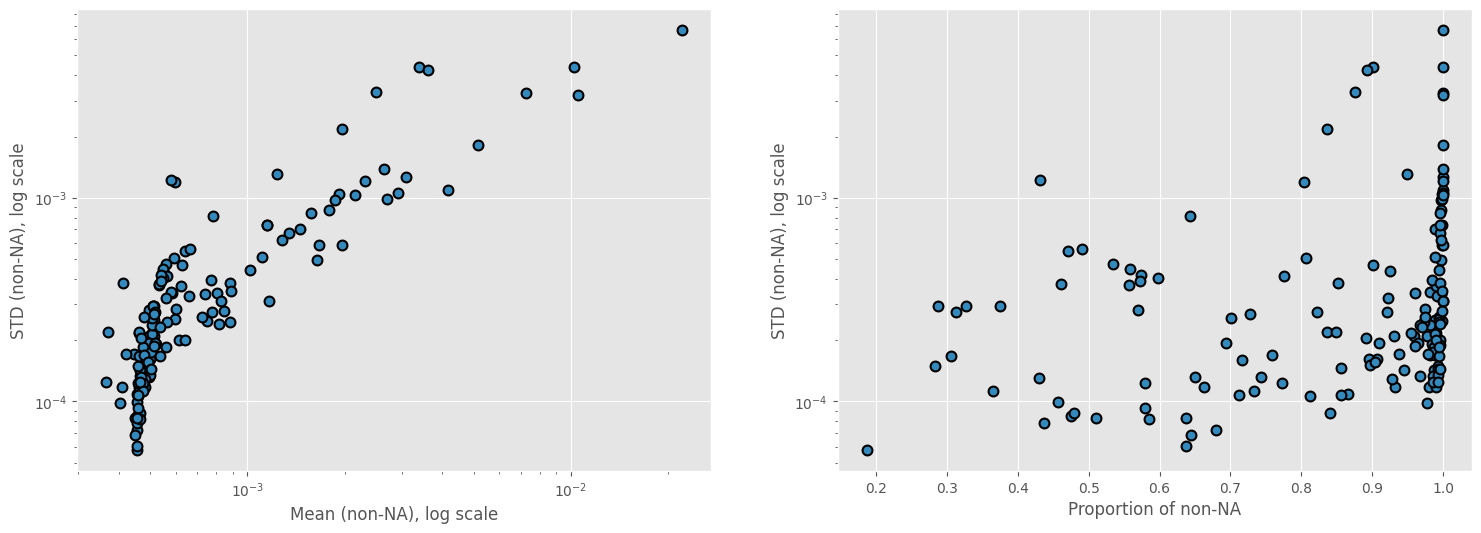

In [129]:
fig = plt.figure(figsize=(18, 6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
x1 = l_s12[l_s12>0.00011].mean(axis = 0).values
x2 = (l_s12[l_s12>0.00011].count()/l_s12.shape[0]).values
y = l_s12[l_s12>0.00011].std(axis = 0).values
#c = np.asarray(data_g['values'][4])

ax1.scatter(x1, y, c='C1', edgecolor='k', linewidth = 1.5, s = 50)
ax2.scatter(x2, y, c='C1', edgecolor='k', linewidth = 1.5, s = 50)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_yscale('log')
#plt.axhline(0.00018)
#plt.axvline(0.00012)
ax1.set_xlabel('Mean (non-NA), log scale')
ax1.set_ylabel('STD (non-NA), log scale')
ax2.set_xlabel('Proportion of non-NA')
ax2.set_ylabel('STD (non-NA), log scale')
#plt.savefig('median_std.pdf', bbox_inches='tight')
plt.show()

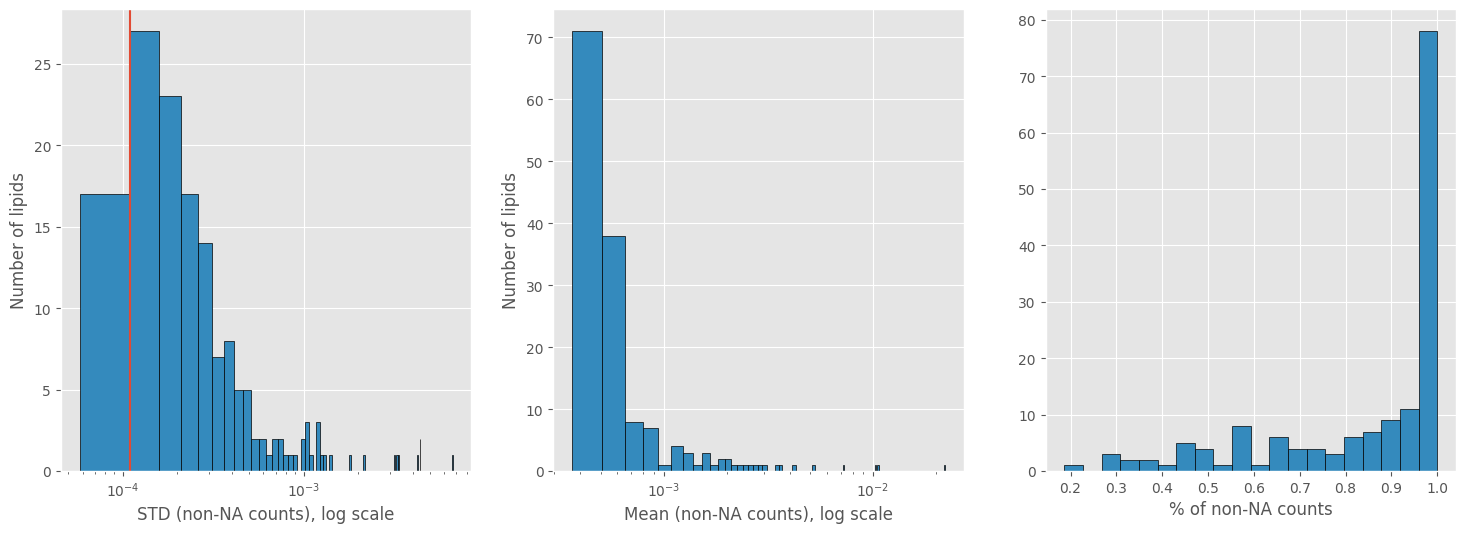

In [143]:
fig = plt.figure(figsize=(18, 6))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
ax1.hist(y, bins = 130, color = 'C1', edgecolor='black')
ax2.hist(x1, bins = 150, color = 'C1', edgecolor='black')
ax3.hist(x2, bins = 20, color = 'C1', edgecolor='black')
for ax in [ax1, ax2]: 
    ax.set_xscale('log')
    ax.set_ylabel('Number of lipids')
ax1.axvline(0.00011)
ax1.set_xlabel('STD (non-NA counts), log scale')
ax2.set_xlabel('Mean (non-NA counts), log scale')
ax3.set_xlabel('% of non-NA counts')
#plt.savefig('/home/lkhachat/shared/std_distr.pdf', bbox_inches='tight')
plt.show()

In [172]:
std_dict = l_s12[l_s12>0.00011].std(axis = 0).to_dict()
non_na_dict = (l_s12[l_s12>0.00011].count()/l_s12.shape[0]).to_dict()
low_imp_lipids = [i for i in std_dict.keys() if (std_dict[i]<0.0001)]



In [336]:
lip_grouping.loc[lip]

Category                Glycerophospholipids
Main_class            Glycerophosphocholines
Sub_class     LPC (Lysophosphatidylcholines)
Name: LPC, dtype: object

In [344]:
n=1000
av = 'neglog'
scale = '_log'
lip_grouping = pd.read_csv('/home/lkhachat/shared/Lipids.csv', index_col = 0)

lipids_types = list(set([i.split(' ')[0].split('(')[0] for i in lipids_names]))
l_results = {}

method_colors_ = {'catboost': '#fff100',
                  'knn': '#009e49',
                  'ridge': '#ec008c'}
method_markers = {'catboost': 'o',
                  'knn': 's',
                  'ridge': 'v'}

for i, lipid in enumerate(lipids_names):
    res = pd.read_csv('results/n_closest/{0}_{1}_{2}{3}.csv'.format(i, str(n), av, scale), index_col = 1).iloc[0].values
    lip = lipid.split(' ')[0].split('(')[0]
    l_results[lipid] = {'best_performance':res[4],
                        'lipid_type': lip,
                        'lipid_type_color': l_type_colors[lip],
                        'lipid_category': lip_grouping.loc[lip]['Category'],
                        'lipid_class': lip_grouping.loc[lip]['Main_class'],
                        'best_algorithm': res[0],
                        'best_algorithm_color': method_colors_[res[0]],
                        'best_algorithm_marker': method_markers[res[0]],
                        'na_composition':non_na_dict[lipid], 
                        'nonna_std': std_dict[lipid],
                        'low_impact':True if lipid in low_imp_lipids else False}


l_results = pd.DataFrame.from_dict(l_results).T

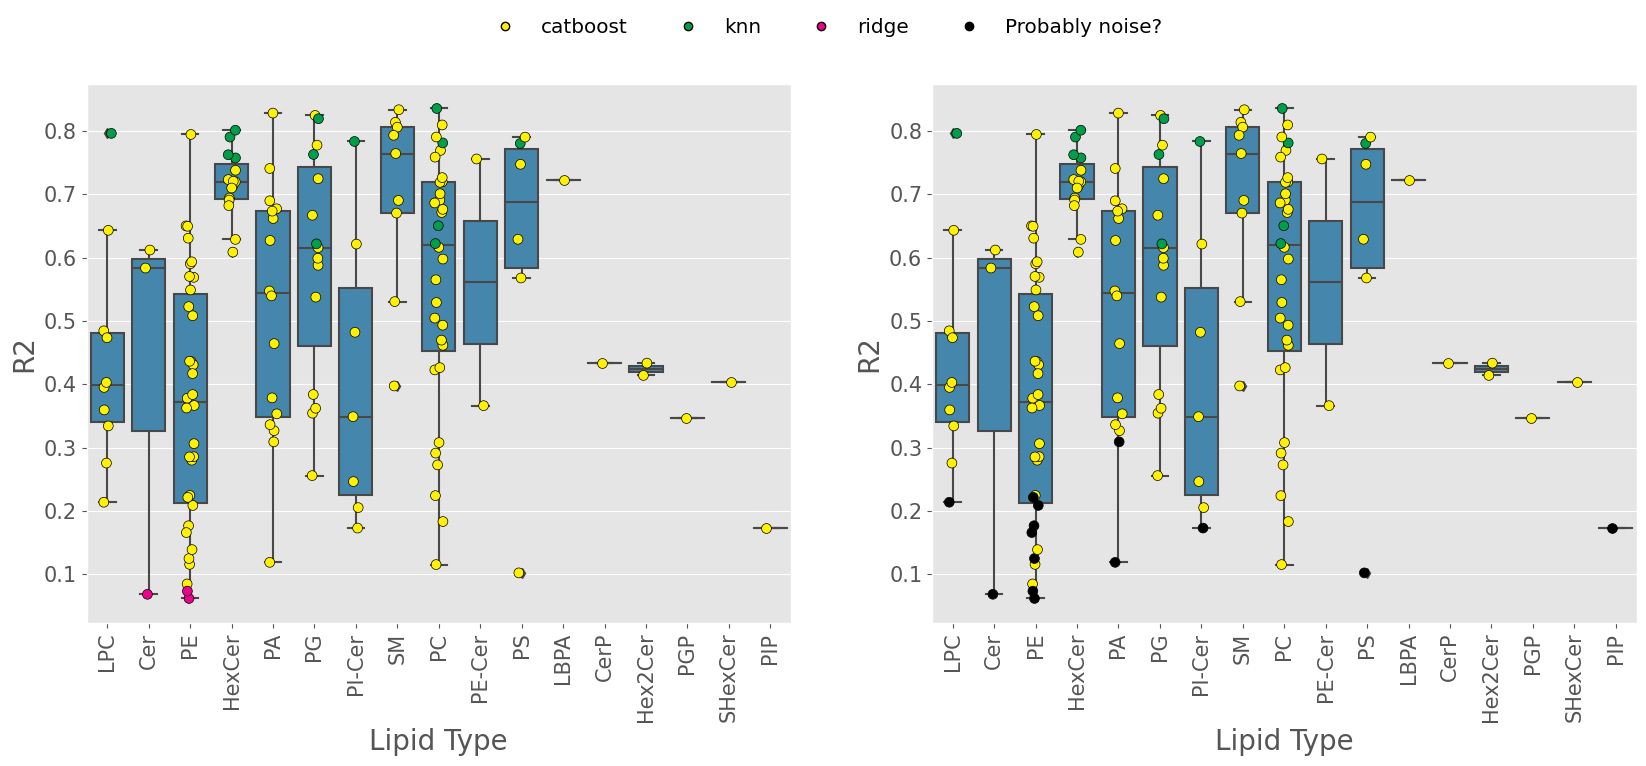

In [345]:
legend_elements = [Line2D([0], [0], marker='o', markerfacecolor=method_colors_[key], 
                           markeredgecolor='k', label=key, linestyle='') for key in method_colors_.keys()]
legend_elements.append(Line2D([0], [0], marker='o', markerfacecolor='k', 
                           markeredgecolor='k', label='Probably noise?', linestyle=''))

fig = plt.figure(figsize=(20, 7))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for ax in [ax1, ax2]:
    a = sns.boxplot(data = l_results, x = 'lipid_', y = 'best_performance', ax = ax, color = 'C1')
    sns_labs = [t.get_text()  for t in a.get_xticklabels()]
    ax.set_xticklabels(sns_labs, rotation = 90, fontsize = 15)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('Lipid Type', fontsize = 20)
    ax.set_ylabel('R2', fontsize = 20)
    
for i, l_type in enumerate(sns_labs):
    tmp_df = l_results[l_results['lipid_type']==l_type]
    color = [tmp_df.loc[i]['best_algorithm_color'] if(tmp_df.loc[i]['low_impact']==False) else 'k' for i in tmp_df.index]
    jit = rand_jitter([i for k in range(tmp_df.shape[0])])
    ax1.scatter(jit, tmp_df['best_performance'],alpha = 1, s = 50, edgecolor = 'k', zorder = 1000,
                c = tmp_df['best_algorithm_color'], )
    
    ax2.scatter(jit, tmp_df['best_performance'], alpha = 1, s = 50, edgecolor = 'k', zorder = 1000,
                c = color, )

fig.legend(handles=legend_elements, fancybox=True, framealpha=0, ncols = 4, loc = 'upper center', 
           fontsize = 'x-large')
plt.show()

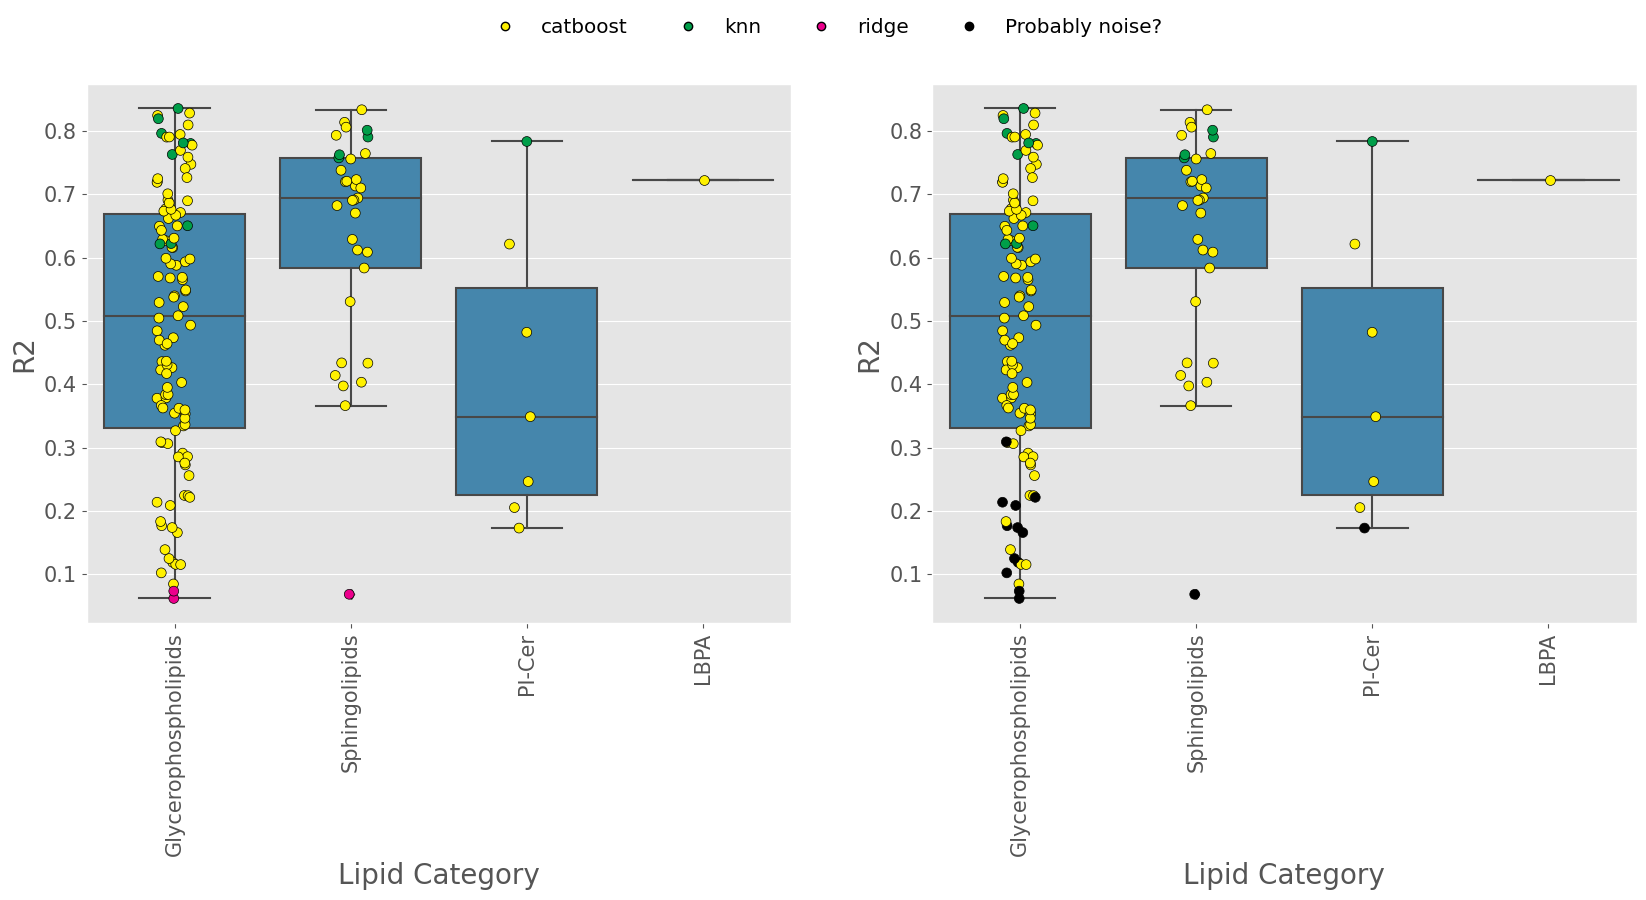

In [348]:
legend_elements = [Line2D([0], [0], marker='o', markerfacecolor=method_colors_[key], 
                           markeredgecolor='k', label=key, linestyle='') for key in method_colors_.keys()]
legend_elements.append(Line2D([0], [0], marker='o', markerfacecolor='k', 
                           markeredgecolor='k', label='Probably noise?', linestyle=''))

fig = plt.figure(figsize=(20, 7))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for ax in [ax1, ax2]:
    a = sns.boxplot(data = l_results, x = 'lipid_category', y = 'best_performance', ax = ax, color = 'C1')
    sns_labs = [t.get_text()  for t in a.get_xticklabels()]
    ax.set_xticklabels(sns_labs, rotation = 90, fontsize = 15)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('Lipid Category', fontsize = 20)
    ax.set_ylabel('R2', fontsize = 20)
    
for i, l_type in enumerate(sns_labs):
    tmp_df = l_results[l_results['lipid_category']==l_type]
    color = [tmp_df.loc[i]['best_algorithm_color'] if(tmp_df.loc[i]['low_impact']==False) else 'k' for i in tmp_df.index]
    jit = rand_jitter([i for k in range(tmp_df.shape[0])])
    ax1.scatter(jit, tmp_df['best_performance'],alpha = 1, s = 50, edgecolor = 'k', zorder = 1000,
                c = tmp_df['best_algorithm_color'], )
    
    ax2.scatter(jit, tmp_df['best_performance'], alpha = 1, s = 50, edgecolor = 'k', zorder = 1000,
                c = color, )

fig.legend(handles=legend_elements, fancybox=True, framealpha=0, ncols = 4, loc = 'upper center', 
           fontsize = 'x-large')
plt.show()

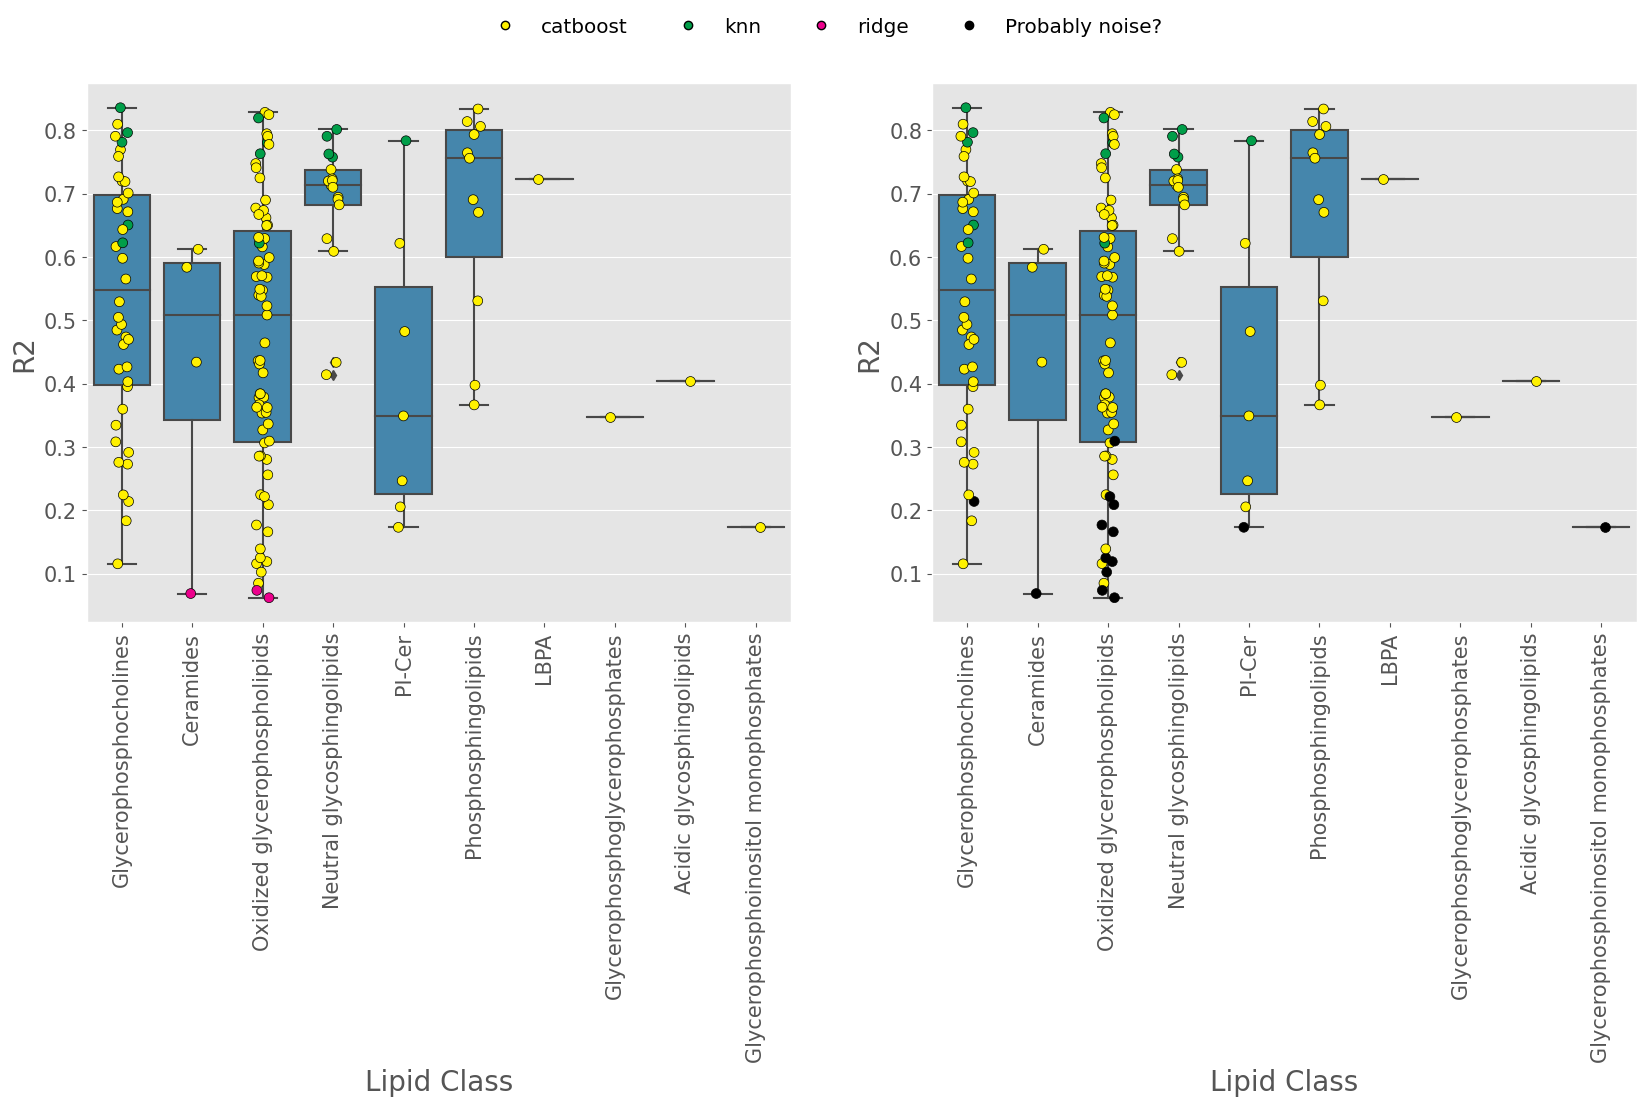

In [349]:
legend_elements = [Line2D([0], [0], marker='o', markerfacecolor=method_colors_[key], 
                           markeredgecolor='k', label=key, linestyle='') for key in method_colors_.keys()]
legend_elements.append(Line2D([0], [0], marker='o', markerfacecolor='k', 
                           markeredgecolor='k', label='Probably noise?', linestyle=''))

fig = plt.figure(figsize=(20, 7))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for ax in [ax1, ax2]:
    a = sns.boxplot(data = l_results, x = 'lipid_class', y = 'best_performance', ax = ax, color = 'C1')
    sns_labs = [t.get_text()  for t in a.get_xticklabels()]
    ax.set_xticklabels(sns_labs, rotation = 90, fontsize = 15)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('Lipid Class', fontsize = 20)
    ax.set_ylabel('R2', fontsize = 20)
    
for i, l_type in enumerate(sns_labs):
    tmp_df = l_results[l_results['lipid_class']==l_type]
    color = [tmp_df.loc[i]['best_algorithm_color'] if(tmp_df.loc[i]['low_impact']==False) else 'k' for i in tmp_df.index]
    jit = rand_jitter([i for k in range(tmp_df.shape[0])])
    ax1.scatter(jit, tmp_df['best_performance'],alpha = 1, s = 50, edgecolor = 'k', zorder = 1000,
                c = tmp_df['best_algorithm_color'], )
    
    ax2.scatter(jit, tmp_df['best_performance'], alpha = 1, s = 50, edgecolor = 'k', zorder = 1000,
                c = color, )

fig.legend(handles=legend_elements, fancybox=True, framealpha=0, ncols = 4, loc = 'upper center', 
           fontsize = 'x-large')
plt.show()

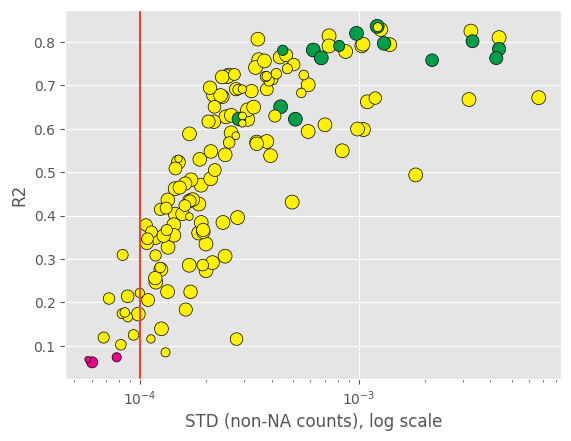

In [314]:
ll = l_results.sort_values(by = 'na_composition', ascending=False)
plt.scatter(ll['nonna_std'], ll['best_performance'], 
            c = list(ll['best_algorithm_color']), edgecolor = 'k', alpha = 1,
            s = list(ll['na_composition']*100))
plt.axvline(0.0001)
plt.ylabel('R2')
plt.xlabel('STD (non-NA counts), log scale')
plt.xscale('log')

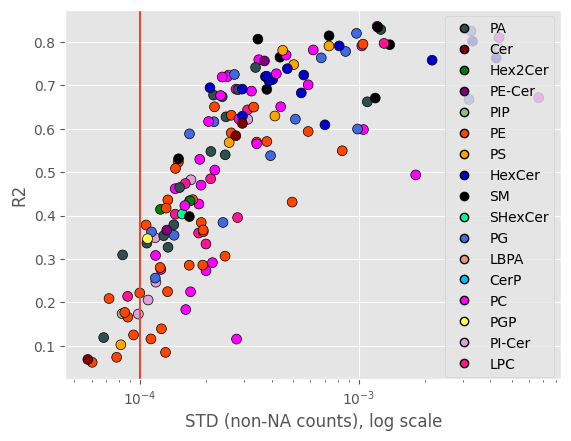

In [350]:
ll = l_results.sort_values(by = 'na_composition', ascending=False)
l_col = ["#2f4f4f","#800000","#008000","#7f007f","#8fbc8f","#ff4500","#ffa500","#0000cd","#000000","#00fa9a",
         "#4169e1","#e9967a","#00bfff","#ff00ff","#ffff54","#dda0dd","#ff1493"]
l_type_colors = {i[0]: i[1] for i in zip(lipids_types, l_col)}
legend_elements = [Line2D([0], [0], marker='o', markerfacecolor=l_type_colors[key], 
                           markeredgecolor='k', label=key, linestyle='') for key in l_type_colors.keys()]

ll = l_results.sort_values(by = 'na_composition', ascending=False)
plt.scatter(ll['nonna_std'], ll['best_performance'], 
            c = list(ll['lipid_type_color']), edgecolor = 'k', alpha = 1,
            s = 50)
plt.axvline(0.0001)
plt.ylabel('R2')
plt.xlabel('STD (non-NA counts), log scale')
plt.xscale('log')
plt.legend(handles=legend_elements)
plt.show()

In [353]:
ll['lipid_category']

PG(34:0)      Glycerophospholipids
PC 34.1       Glycerophospholipids
PG(36:1)      Glycerophospholipids
PA(34:1)      Glycerophospholipids
PC 32:0       Glycerophospholipids
                      ...         
Cer 42:2             Sphingolipids
SM(t42:1)            Sphingolipids
Cer 40:2             Sphingolipids
SM(t40:1)            Sphingolipids
Cer 36:1             Sphingolipids
Name: lipid_category, Length: 156, dtype: object

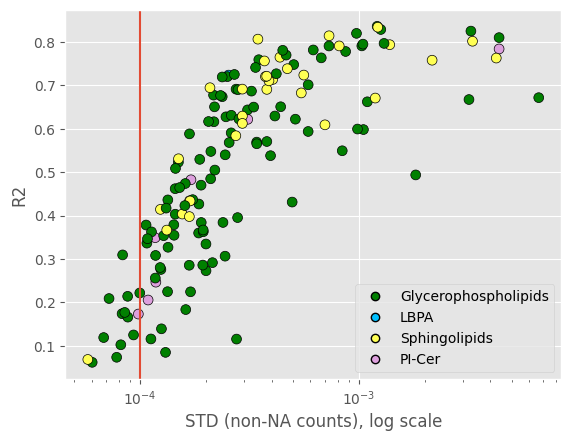

In [355]:
ll = l_results.sort_values(by = 'na_composition', ascending=False)
l_col = ["#008000","#00bfff","#ffff54","#dda0dd"]
l_cat_colors = {i[0]: i[1] for i in zip(list(set(ll['lipid_category'])), l_col)}
legend_elements = [Line2D([0], [0], marker='o', markerfacecolor=l_cat_colors[key], 
                           markeredgecolor='k', label=key, linestyle='') for key in l_cat_colors.keys()]

ll = l_results.sort_values(by = 'na_composition', ascending=False)
plt.scatter(ll['nonna_std'], ll['best_performance'], 
            c = [l_cat_colors[i] for i in list(ll['lipid_category'])], edgecolor = 'k', alpha = 1,
            s = 50)
plt.axvline(0.0001)
plt.ylabel('R2')
plt.xlabel('STD (non-NA counts), log scale')
plt.xscale('log')
plt.legend(handles=legend_elements)
plt.show()

In [ ]:
ll = l_results.sort_values(by = 'na_composition', ascending=False)
plt.scatter(ll['nonna_std'], ll['best_performance'], 
            c = [method_colors_[i] for i in ll['best_algorithm']], edgecolor = 'k', alpha = 1,
            s = list(ll['na_composition']*100))
plt.axvline(0.0001)
plt.ylabel('R2')
plt.xlabel('STD (non-NA counts), log scale')
plt.xscale('log')

In [118]:
import random

def rand_jitter(array):
    return([i+random.uniform(-1, 1)/10 for i in array])

In [18]:
res_per_type = {l_type:[] for l_type in lipids_types}
for lipid in lipids_names: res_per_type[lipid.split(' ')[0].split('(')[0]].append(l_results[lipid]['best_performance'])

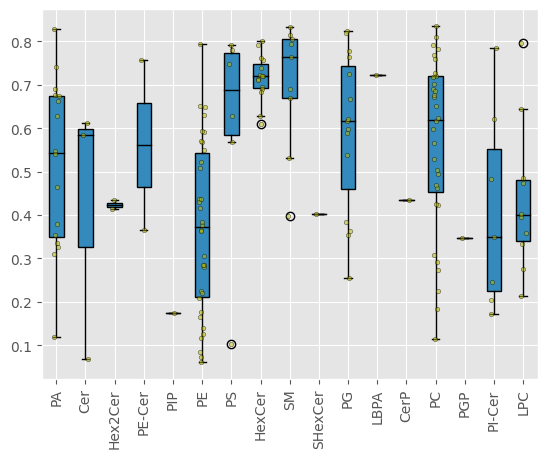

In [47]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
bp_data = [res_per_type[i] for i in res_per_type.keys()]
plt.boxplot(bp_data, patch_artist=True, medianprops=dict(color='k'))
plt.xticks(range(1, 18), labels = list(res_per_type.keys()), rotation = 90)

for i in range(17):
    plt.scatter(rand_jitter([i+1 for k in bp_data[i]]), bp_data[i],
                alpha = 0.5, s = 10, c = 'y', edgecolor = 'k', zorder = 20)
plt.show()

In [ ]:
for i in range(128, 157):
    
    files = [k for k in os.listdir('results/n_closest') if '{0}_1000_neglog_log'.format(i) in k]
    for file in files:
        prefile = '_'.join(file.split('/')[-1].split('_')[1:])
        os.rename('results/n_closest/' + file, 
              'results/n_closest/' + str(i-1)+'_'+prefile)